<a href="https://colab.research.google.com/github/swethasrihari/NLP/blob/main/NLP_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
training_path ='/content/drive/MyDrive/Colab Notebooks/sentiment_train.json'
test_path = '/content/drive/MyDrive/Colab Notebooks/hw2_sentiment_test.json'


In [ ]:
train_data = pd.read_json(training_path, lines=True)

In [ ]:
test_data = pd.read_json(test_path, lines= True)

In [ ]:
def extract_required_columns(dataset):
  stars = []
  review_title = []
  for record in dataset.values:
    stars.append(record[3])
    review_title.append(record[5].lower())
  return stars,review_title

In [ ]:
stars, review_title = extract_required_columns(train_data)
test_stars, test_review_title = extract_required_columns(test_data)


Preprocessing data by removing punctutions, lower casing and tokenizing

In [ ]:
import nltk

def split_into_words(review_title):
  tokens = []
  for review in review_title:
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    words = tokenizer.tokenize(review)
    tokens.append(words)
  return tokens

tokens = split_into_words(review_title)
test_tokens = split_into_words(test_review_title)

In [ ]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']



**word2vec-google-news-300:**
 * This model is trained on a dataset that contains news articles from Google News.
 * It's trained on a very large corpus, consisting of billions of words.
 * The data comes from a diverse range of news sources, covering a wide array of topics.
 * The vocabulary contains words that are commonly used in news articles.
 * It's based on predicting the context words given a target word (Continuous Bag of Words, CBOW) or predicting a target word given its context (Skip-gram).
 * Two main architectures are CBOW and Skip-gram.

**glove-wiki-gigaword-300:**

 * This model is trained on a combination of Wikipedia and parts of the Gigaword dataset.
 * While still large, it may not be as massive as the Google News dataset.
 * As Wikipedia covers a wide range of subjects, it provides a broad general knowledge base.
 * It contains words commonly found in both encyclopedic articles (Wikipedia) and news documents (Gigaword).
 * It combines global statistics of word co-occurrences and local context window statistics.
 * It aims to learn word vectors that capture both syntactic and semantic word relationships.


In [ ]:
word2vec = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
glove = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
emotion_words = ['happy','sad','angry','joy','frustrated', 'disgusted','alarmed','ecstatic', 'hopeful']
emotion_words_subset = [word2vec[word] for word in emotion_words]

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=1)
word_vectors_2d = tsne.fit_transform(np.array(emotion_words_subset))

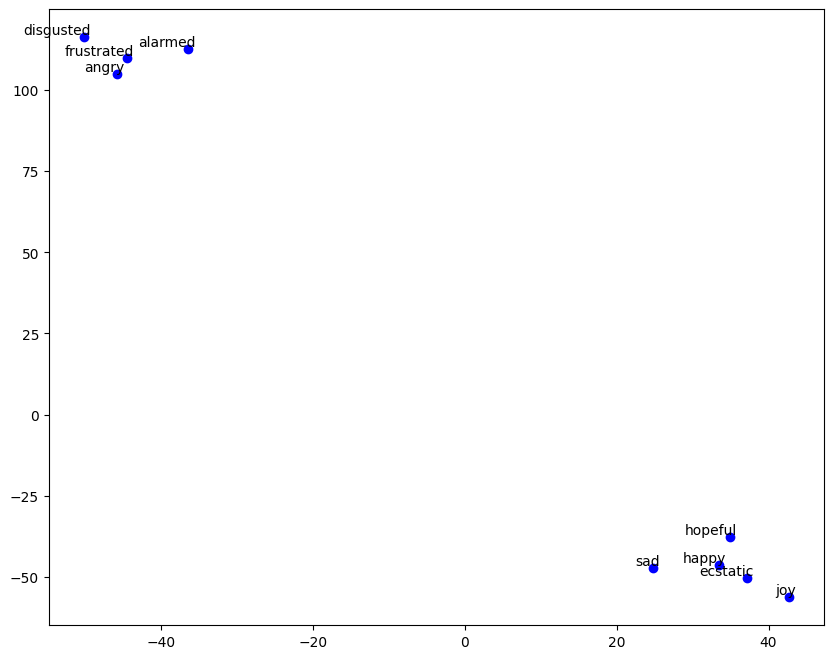

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c='b', marker='o')

for i, word in enumerate(emotion_words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5,2), textcoords='offset points', ha='right')

plt.show()

In [ ]:
gender_words = ['man', 'woman', 'doctor', 'nurse', 'engineer', 'teacher','scientist','lawyers', 'homemaker','chef','king','queen']
gender_words_subset = [word2vec[word] for word in gender_words]

In [ ]:
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=2)
word_vectors_2d = tsne.fit_transform(np.array(gender_words_subset))

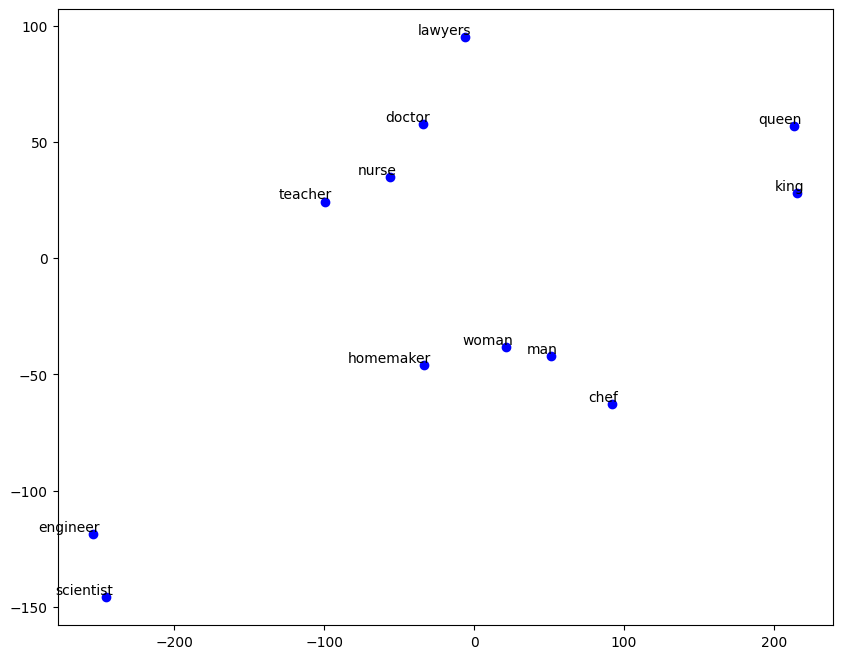

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c='b', marker='o')

for i, word in enumerate(gender_words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5,2), textcoords='offset points', ha='right')

plt.show()

We can see that Chef is close to man and homemaker is close to women when we project the words in the graph. This shows the gender bias in the training data.

In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

def average_word_vectors(tokens, model):
    vectorized_word = []
    for words in tokens:
        valid_words = [word for word in words if word in model]
        if valid_words:
            vectorized_word.append(np.mean([model[word] for word in valid_words], axis=0))
        else:
            vectorized_word.append(np.zeros(model.vector_size))
    return vectorized_word

x_train = average_word_vectors(tokens, word2vec)
x_test= average_word_vectors(test_tokens,word2vec)
y_train = stars
y_test = test_stars
reg = LogisticRegression().fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred = reg.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print("Classification report for word2vec")
print(report)
from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred))

Classification report for word2vec
              precision    recall  f1-score   support

           1       0.90      0.91      0.90      1000
           5       0.91      0.90      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Confusion Matrix : 
[[906  94]
 [100 900]]


In [ ]:
x_train = average_word_vectors(tokens, glove)
x_test= average_word_vectors(test_tokens,glove)
reg = LogisticRegression().fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
y_pred = reg.predict(x_test)
report = classification_report(y_test, y_pred)
print("Classification report for Glove")
print(report)
print("Confusion Matrix : ")
print(confusion_matrix(y_test, y_pred))

Classification report for Glove
              precision    recall  f1-score   support

           1       0.89      0.91      0.90      1000
           5       0.90      0.89      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Confusion Matrix : 
[[906  94]
 [115 885]]


The models produced similar results but the Word2Vec model gave 1% better precision than the Glove model.
In the previous assignment, the logistic regression model performed with 93% precision, recall, F1-score and accuracy.The current models produced 90% acuracy, precision, recall and F1-score.

In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-recommended
!pip install nbconvert
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/NLP_HW2.ipynb";

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [555 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,009 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,274 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.